# 🎬 IMDB Movie Rating Prediction with Ridge Regression

**Project Goal:** To predict the rating of a movie based on various features such as votes, runtime, director, cast, genre, and description.

**Methodology:**
We will adopt an **iterative approach**, starting with a baseline model and progressively adding complexity:
1.  **Baseline Model:** Using only raw numerical features.
2.  **Basic Feature Engineering:** Log-transforms and One-Hot Encoding.
3.  **Advanced Feature Engineering:** Smoothed Target Encoding for high-cardinality categorical features (Actors/Directors).
4.  **NLP Integration:** Extracting semantic information from text descriptions using TF-IDF.

**Model:** Ridge Regression (L2 Regularization) is chosen to handle multicollinearity and prevent overfitting.

---

## 1. Importing Required Libraries
We begin by importing all the libraries needed for data handling, feature engineering, and model building.

In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

## 2. Defining Constant Threshold Values

These values help filter noisy samples and stabilize the smoothing encodings.

In [267]:
# Configuration Constants
MIN_VOTES = 100       # Exclude movies with very few votes to ensure reliability
MIN_RUNTIME = 60      # Exclude shorts (less than 1 hour)
SMOOTH_FACTOR = 10     # Smoothing parameter for Target Encoding (prevents overfitting on rare categories)

## 3. Loading and Cleaning the Dataset

We load the raw dataset and immediately apply filtering to remove "noise."

In [268]:
df = pd.read_csv('IMDB_cleaned.csv')

# Movies with very few votes are unreliable outliers.
df = df[df['votes'] > MIN_VOTES]

# Very short films (shorts) might behave differently from feature films.
df = df[df['runtime'] >= MIN_RUNTIME]

print(f"Number of films after filtering: {len(df)}")

Number of films after filtering: 39238


## 4. Feature–Target Separation

We prepare our feature matrix and target vector.

In [269]:
X = df[['votes', 'runtime', 'director', 'stars', 'genre', 'description']]
y = df['rating']

## 5. Train–Test Split

Separate the dataset into training and test subsets.

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6. Model evaluation function

This function sets up a Pipeline (Scaler + Ridge) for the given X and y data, finds the best Alpha using GridSearch, and reports the results.

In [271]:
def evaluate_model(X_train, X_test, y_train, y_test, pipeline=None):
    
    """
    Trains a Ridge Regression model using GridSearchCV and evaluates it.
    """
    
    # 1. Create pipeline if it's not given
    if pipeline is None:
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge())
        ])
    
    # 2. Hyperparameter Grid
    # We search through a logarithmic scale of alphas to find the optimal regularization strength
    params = {
        "ridge__alpha": np.logspace(0, 10, 50) 
    }
    
    # 3. Grid Search (Cross-Validation)
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        cv=5,            
        scoring="r2",    
        n_jobs=-1
    )
    
    # 4. Train the model
    grid.fit(X_train, y_train)
    
    # 5. Best Model & Predictions
    best_model = grid.best_estimator_
    best_alpha = grid.best_params_["ridge__alpha"]

    # Predictions for both sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # 6. Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # 7. Report
    print(f"\n--- Model Evaluation Results ---")
    print(f"Best Alpha      : {best_alpha:.2f}")
    print(f"Training R²     : {train_r2:.4f}")
    print(f"Test R²         : {test_r2:.4f}")
    print(f"Training RMSE   : {train_rmse:.4f}")
    print(f"Test RMSE       : {test_rmse:.4f}")
    
    # Simple Overfitting Check
    if train_r2 > test_r2 + 0.10:
        print("Warning: Risk of Overfitting detected!")
    else:
        print("Model appears balanced.")
    print("-" * 32 + "\n")
    
    return y_test_pred, best_model

## 7. Baseline Model

We start with a simple baseline to establish a minimum performance benchmark. 

**Strategy:** We drop complex features like **director**, **stars**, **genre**, and **description** because they require advanced preprocessing.
* We use only raw numerical features (**votes**, **runtime**).

In [272]:
X_train_v1 = X_train.drop(columns=['director', 'stars', 'genre', 'description'])
X_test_v1 = X_test.drop(columns=['director', 'stars', 'genre', 'description'])

y_pred = evaluate_model(X_train_v1, X_test_v1, y_train, y_test)


--- Model Evaluation Results ---
Best Alpha      : 109.85
Training R²     : 0.0788
Test R²         : 0.0880
Training RMSE   : 1.2580
Test RMSE       : 1.2602
Model appears balanced.
--------------------------------



**Observation:** The baseline model performs very poorly. This confirms that raw numerical features alone (**votes** and **runtime**) are not enough to predict movie ratings. We absolutely need to process the categorical and text data to improve the model.

## 8. Basic Feature Engineering

### 8.1 Log Transformation of Votes

The number of votes follows a exponentional distribution (a few movies have millions, most have very few). We applied a log transformation to squash these large values and make the distribution more normal.

In [273]:
# Apply Log transformation (Log(1+x) handles zero values safely)
X_train['log_votes'] = np.log1p(X_train['votes'])
X_test['log_votes'] = np.log1p(X_test['votes'])

# Drop the original 'votes' column to avoid multicollinearity
X_train = X_train.drop(columns=['votes'])
X_test = X_test.drop(columns=['votes'])

### 8.2 One-Hot Encoding Genres

A movie can belong to multiple genres (e.g., "Action, Comedy, Sci-Fi"). We cannot treat this as a simple category.

In [274]:
# 1. Clean spacing
X_train['genre'] = X_train['genre'].str.replace(' ', '')
X_test['genre'] = X_test['genre'].str.replace(' ', '')

# 2. Split genres by comma and get dummy variables
train_genres = X_train['genre'].str.get_dummies(sep=',')
test_genres = X_test['genre'].str.get_dummies(sep=',')

# 3. Join with main dataframe
X_train = pd.concat([X_train, train_genres], axis=1).drop(columns=['genre'])
X_test = pd.concat([X_test, test_genres], axis=1).drop(columns=['genre'])

# 4. ALIGNMENT: Ensure Test columns match Train columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"Training shape after encoding: {X_train.shape}")

Training shape after encoding: (31390, 31)


#### 8.3 Model Evaluation (Basic Features)

We now test the model performance using the transformed basic features:
* Log transformed votes **log_votes**
* **runtime**
* One-Hot Encoded **genres**

In [275]:
# We drop the advanced features (Director, Stars, Description) for now
# to see the impact of ONLY Basic Engineering (Log Votes + Genres)
cols_to_drop = ['director', 'stars', 'description']

X_train_v2 = X_train.drop(columns=cols_to_drop)
X_test_v2 = X_test.drop(columns=cols_to_drop)

y_pred = evaluate_model(X_train_v2, X_test_v2, y_train, y_test)


--- Model Evaluation Results ---
Best Alpha      : 68.66
Training R²     : 0.3847
Test R²         : 0.3744
Training RMSE   : 1.0281
Test RMSE       : 1.0438
Model appears balanced.
--------------------------------



**Observation:**
The feature engineering steps (Log-transforming votes and One-Hot Encoding genre) led to a improvement, raising the R^2 score.

This confirms that:
1.  Correcting the skewness in votes helped the linear model significantly.
2.  Genre is a strong predictor of movie ratings.

## 9. Advanced Feature Engineering

### 9.1 Helper Function: Smoothed Encoding Calculation

First, we define a helper function that calculates the weighted average rating for a category (like an Actor or Director).
This function uses **smoothing** to prevent overfitting on rare categories.

$$Score = \frac{count \times mean + m \times global\_mean}{count + m}$$

In [276]:
def calc_smooth_mean(df, by_col, on_col, m=10):
    """
    Calculation Function:
    Groups by a given column (by_col) and calculates the mean of the target column (on_col).
    """
    # Global mean
    global_mean = df[on_col].mean()
    
    # Grouping and Statistics
    agg = df.groupby(by_col)[on_col].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    
    # Smoothing Formula
    smooth_score = (counts * means + m * global_mean) / (counts + m)
    
    return smooth_score, global_mean

### 9.2 Applying to Training Set (with K-Fold)

**Critical Step:** To prevent Data Leakage, we cannot simply use the average of the whole training set. If we do, the model sees the movie's own rating inside the actor's score (cheating).

**Solution:** We use **K-Fold Logic**.
1. We split the Training data into 5 parts.
2. For each part, we calculate actor scores using **only the other 4 parts**.
3. This ensures the model predicts a movie's quality using only **other movies'** data.

In [277]:
def get_train_scores(X_train, y_train, col_name, m=10):
    """
    Generates scores for training data using K-Fold method (Prevents leakage).
    """
    # Create a temporary dataframe (X and y together)
    temp_df = X_train.copy()
    temp_df['rating'] = y_train
    
    # Empty series to store results
    oof_scores = pd.Series(index=X_train.index, dtype=float)
    
    # Split data into 5 parts
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(temp_df):
        # Split: 80% Training (train_fold), 20% Validation (val_fold)
        train_fold = temp_df.iloc[train_idx]
        val_fold = temp_df.iloc[val_idx]
        
        if col_name == 'stars':
            # For actors (Multi-value: "Brad Pitt, Tom Cruise")
            # 1. Calculate scores on Train Fold
            exploded_train = train_fold.assign(actor=train_fold['stars'].str.split(',')).explode('actor')
            exploded_train['actor'] = exploded_train['actor'].str.strip()
            actor_map, global_mean = calc_smooth_mean(exploded_train, 'actor', 'rating', m=m)
            
            # 2. Apply these scores to Val Fold
            exploded_val = val_fold.assign(actor=val_fold['stars'].str.split(',')).explode('actor')
            exploded_val['actor'] = exploded_val['actor'].str.strip()
            exploded_val['score'] = exploded_val['actor'].map(actor_map).fillna(global_mean)
            
            # 3. Take average per movie and save
            fold_result = exploded_val.groupby(level=0)['score'].mean()
            oof_scores.iloc[val_idx] = fold_result
            
        else:
            # For director (Single value: "Christopher Nolan")
            target_map, global_mean = calc_smooth_mean(train_fold, col_name, 'rating', m=m)
            oof_scores.iloc[val_idx] = val_fold[col_name].map(target_map).fillna(global_mean)
            
    return oof_scores

# --- APPLICATION ---
X_train['cast_score'] = get_train_scores(X_train, y_train, 'stars', m=10)
X_train['director_score'] = get_train_scores(X_train, y_train, 'director', m=10)

### 9.3 Applying to Test Set

For the **Test Set**, we don't need K-Fold. We want our model to use **all available knowledge**.
So, we calculate actor/director scores using the **entire Training Set** and map them to the Test Set.

In [278]:
def get_test_scores(X_train, y_train, X_test, col_name, m=10):
    """
    Scores the Test set using the entire training set.
    """
    # Combine all Training data
    full_train = X_train.copy()
    full_train['rating'] = y_train
    
    if col_name == 'stars':
        # Calculate for actors
        exploded = full_train.assign(actor=full_train['stars'].str.split(',')).explode('actor')
        exploded['actor'] = exploded['actor'].str.strip()
        actor_map, global_mean = calc_smooth_mean(exploded, 'actor', 'rating', m=m)
        
        # Apply to Test set
        exploded_test = X_test.assign(actor=X_test['stars'].str.split(',')).explode('actor')
        exploded_test['actor'] = exploded_test['actor'].str.strip()
        exploded_test['score'] = exploded_test['actor'].map(actor_map).fillna(global_mean)
        
        return exploded_test.groupby(level=0)['score'].mean()
        
    else:
        # Calculate for director
        target_map, global_mean = calc_smooth_mean(full_train, col_name, 'rating', m=m)
        return X_test[col_name].map(target_map).fillna(global_mean)

# --- APPLICATION ---
X_test['cast_score'] = get_test_scores(X_train, y_train, X_test, 'stars', m=10)
X_test['director_score'] = get_test_scores(X_train, y_train, X_test, 'director', m=10)

# Drop unnecessary columns
cols_to_drop = ['stars', 'director']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

### 9.4 Model evaluation after advanced feature engineering
Now we are testing the model's performance using the added advanced features:

* Weighted average of actors **Cast Score**
* Smoothed **Director Score**

In [279]:
X_train_v3 = X_train.drop(columns=['description'])
X_test_v3 = X_test.drop(columns=['description'])

y_pred = evaluate_model(X_train_v3, X_test_v3, y_train, y_test)


--- Model Evaluation Results ---
Best Alpha      : 68.66
Training R²     : 0.4568
Test R²         : 0.4531
Training RMSE   : 0.9660
Test RMSE       : 0.9759
Model appears balanced.
--------------------------------



**Observation:**
Incorporating the Cast and Director scores has notably improved the model's performance compared to the basic version.

* The increase in R^2 Score indicates that the reputation and past performance of the director and actors are strong predictors of a movie's rating.

This confirms that Smoothed Target Encoding adds valuable information that raw numerical features alone cannot provide.

## 10. NLP Feature Engineering
### 10.1 Description

The movie description often contains keywords that signal the movie's tone or quality.

1.  **Text Cleaning:** Remove artifacts like "See full summary..." and ellipses.
2.  **TF-IDF Vectorization:** We convert the raw text into numerical vectors using **TF-IDF**. This downweights common words (like "the", "a") and highlights rare, informative words.

In [280]:
# 1. Handle Missing Values
X_train['description'] = X_train['description'].fillna('')
X_test['description'] = X_test['description'].fillna('')

# 2. Text Cleaning (Regex)
# Removes "See full summary..." and trailing "..."
clean_pattern = r'See full summary.*|\.{3,}$'
X_train['description'] = X_train['description'].astype(str).str.replace(clean_pattern, '', regex=True).str.strip()
X_test['description'] = X_test['description'].astype(str).str.replace(clean_pattern, '', regex=True).str.strip()

# 3. Define Column Transformer
# We identify the text column vs. numerical columns
text_col = 'description'
num_cols = [col for col in X_train.columns if col != text_col]

preprocessor = ColumnTransformer(
    transformers=[
        # Apply Standard Scaling to numeric features
        ('num', StandardScaler(), num_cols),
        # Apply TF-IDF to text feature (limit to top 1000 words to prevent overfitting)
        ('text', TfidfVectorizer(max_features=1000, stop_words='english'), text_col)
    ]
)

# 4. Create the Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

### 10.2 Final Model Evaluation

Finally, we are adding the description feature and testing it.

In [281]:
y_pred, best_model = evaluate_model(X_train, X_test, y_train, y_test, pipeline)


--- Model Evaluation Results ---
Best Alpha      : 16.77
Training R²     : 0.4955
Test R²         : 0.4668
Training RMSE   : 0.9310
Test RMSE       : 0.9636
Model appears balanced.
--------------------------------



**Observation:**
By adding the TF-IDF features from the movie description, we see our final performance metrics.

* The text data provides subtle context that numerical features miss.
* While the improvement might be smaller compared to previous steps, it represents the fine-tuning stage of our model.

**Conclusion:**
We successfully improved the model from a baseline R^2 score to a much stronger final score by iteratively adding **Mathematical Transformations** (Log), **Domain Knowledge** (Cast/Director Scores), and **NLP** (Description).

## 11. Visualization of Results

### 11.1 Predicted vs. Actual Scatter Plot

We plot the Actual ratings (X-axis) against our Predicted ratings (Y-axis). 
* The **red dashed line** represents a perfect prediction.
* Points closer to this line are accurate.
* Points far from the line represent errors. 

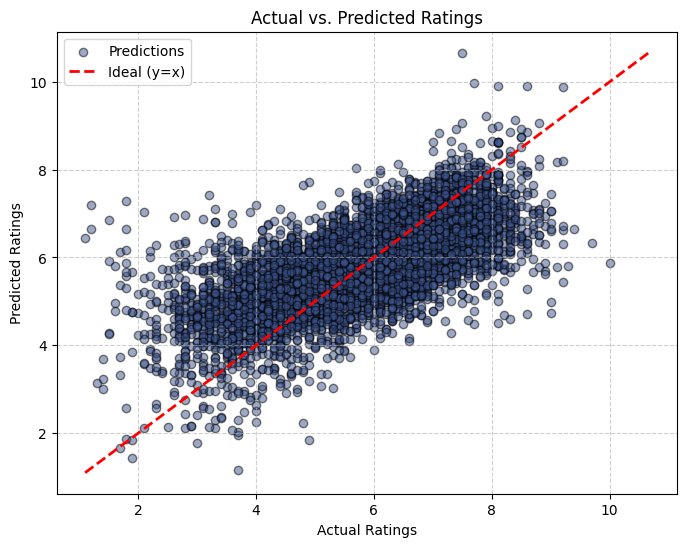

In [282]:
plt.figure(figsize=(8, 6))

# Main scatter plot
plt.scatter(y_test, y_pred, alpha=0.5, color='#3b528b', edgecolor='k', label='Predictions')

# Reference Line (Perfect Prediction)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (y=x)')

plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs. Predicted Ratings")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This scatter plot shows that the model generally predicts ratings in the right direction. Most points are close to the diagonal line, which means the predicted values are usually similar to the real values.

But the points spread out more, especially for ratings between 6 and 8. This tells us the model is not perfect and sometimes makes bigger mistakes. This is normal because movie ratings depend on many subjective things, like personal taste or story quality, which are hard to capture with data.

### 11.2 Residual Plot

This plot checks for **bias**. 
* We want to see a random cloud of points centered around the red line (0 error).
* If we saw a curve (U-shape), it would imply our linear model is missing a non-linear pattern.
* Our plot shows a mostly random distribution, confirming that Ridge Regression was an appropriate choice.

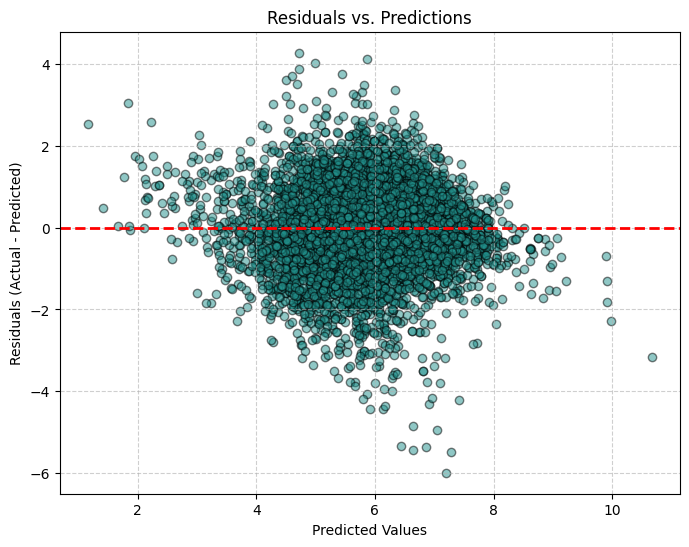

In [283]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='#21918c', edgecolor='k')
plt.axhline(0, color='r', linestyle='--', lw=2)

plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predictions")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In the residual plot, the points are spread around zero without forming any pattern. This is a good sign because it means:

* No major violation of linearity assumptions,
* No systematic bias in the predictions,
* Variance that is roughly constant.

However, the residuals still have a wide range, meaning some predictions are far from the real values. This matches what we saw before predicting movie ratings can be difficult because many factors are subjective.

### 11.3 Error Distribution

The histogram shows the spread of our errors.

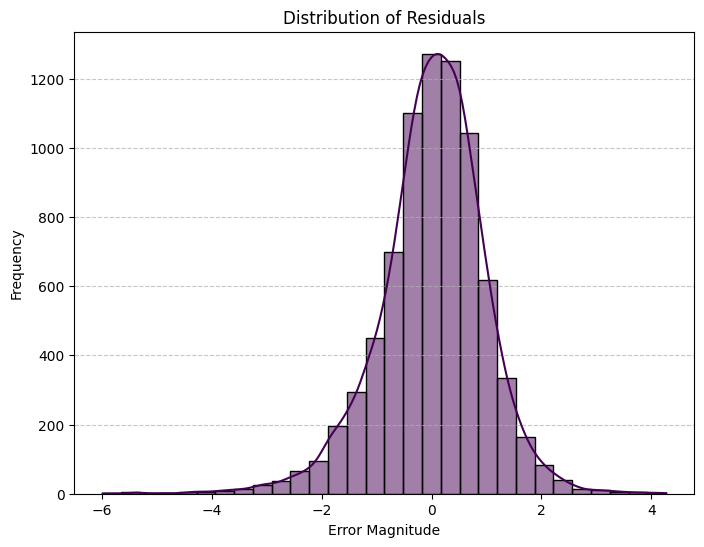

In [284]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='#440154', bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Error Magnitude")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The error distribution looks like a bell-shaped curve centered around zero. This means:

* The errors are mostly normal and balanced,
* The model doesn’t consistently guess too high or too low,
* Most predictions are close to the real rating.

There are a few errors that are larger than usual, but this is expected in real datasets, especially when dealing with human opinions like movie ratings.

### 11.4 Learning Curve Analysis

The Learning Curve helps us diagnose bias and variance by plotting the model's performance on the training set and the validation set.

* **Training Score (Red):** How well the model learns from the data it has seen.
* **Cross-Validation Score (Green):** How well the model generalizes to new, unseen data.

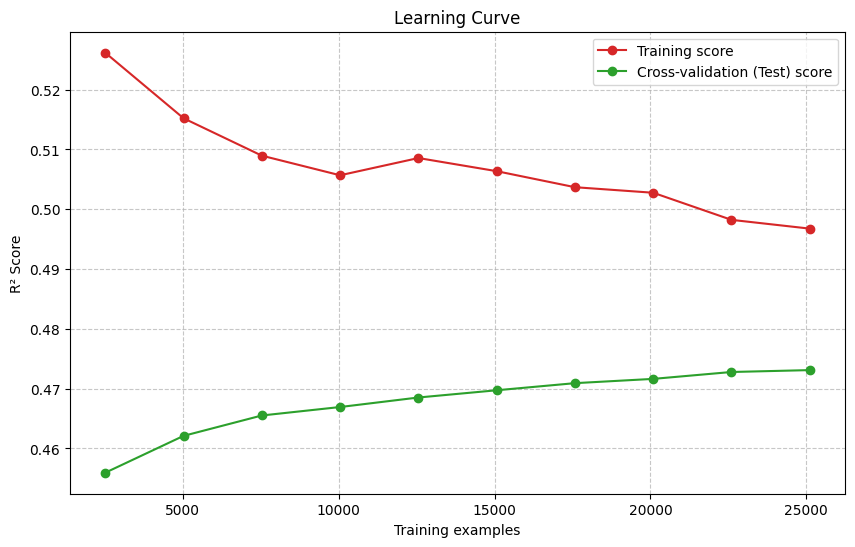

In [285]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#d62728", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2ca02c", label="Cross-validation (Test) score")
    
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("R² Score")
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Run the plot
plot_learning_curve(best_model, X_train, y_train)

**Observation:**

The learning curve reveals critical insights about the model's behavior:

1.  **Saturation Point:** After about 20,000 samples, the scores stop changing much and the lines move together. This means the model has learned as much as it can from the current features.
2.  **Data Sufficiency:** Since the lines are flattening out, adding more movies to the dataset won't help much. The slow rise of the green line shows that we already have enough data to understand the patterns.